In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import seaborn
import matplotlib.pyplot as plt

In [2]:
# read data from json file

import json

data = json.load(open('training_data/training_data.json'))

data.keys()

dict_keys(['EVDUQ', 'EtEUA', 'EtFVg', '0BLVw', 'UtGVw', 'EtKUA', 'ENEVQ', 'URAUw', 'kJBUQ', 'EJKVg', '0ZAVg', 'EtAUg', '0REVg', 'UFHVw', 'ERHUw', 'EBHUg', '0RCVw', 'UdAUA', 'kdDVQ', 'EBCXQ', 'UJKXA'])

In [3]:
# for each key in data, get the data by one user

data['EVDUQ'].keys()

dict_keys(['back', 'left', 'right', 'age', 'height', 'weight', 'gender'])

In [4]:
# for each posture, 3 iid observations are collected
np.array(data['EVDUQ']['back']).shape

(3, 24, 32)

In [5]:
# select 6 random user for test set and rest for training set

np.random.seed(0)

test_users = np.random.choice(list(data.keys()), 6, replace=False)

# select 3 random user for validation set and rest for training set

val_users = np.random.choice([user for user in data.keys() if user not in test_users], 3, replace=False)

train_users = [user for user in data.keys() if user not in test_users]

train_users = [user for user in train_users if user not in val_users]

print('test_users: ', test_users)
print('val_users: ', val_users)
print('train_users: ', train_users)

test_users:  ['kJBUQ' 'UFHVw' 'UJKXA' 'EtEUA' 'EtAUg' '0ZAVg']
val_users:  ['0RCVw' 'UdAUA' 'EBHUg']
train_users:  ['EVDUQ', 'EtFVg', '0BLVw', 'UtGVw', 'EtKUA', 'ENEVQ', 'URAUw', 'EJKVg', '0REVg', 'ERHUw', 'kdDVQ', 'EBCXQ']


In [6]:
# create training set and test set

train_set = []
posture_list = ['back','left','right']

posture_list_id = {'back':0,'left':1,'right':2}

for user in train_users:
    for posture in posture_list:
        for i in range(3):
            train_set.append({'x':np.array(data[user][posture][i]), 'y':np.array(posture_list_id[posture])})

test_set = []

for user in test_users:
    for posture in posture_list:
        for i in range(3):
            test_set.append({'x':np.array(data[user][posture][i]), 'y':np.array(posture_list_id[posture])})

val_set = []

for user in val_users:
    for posture in posture_list:
        for i in range(3):
            val_set.append({'x':np.array(data[user][posture][i]), 'y':np.array(posture_list_id[posture])})

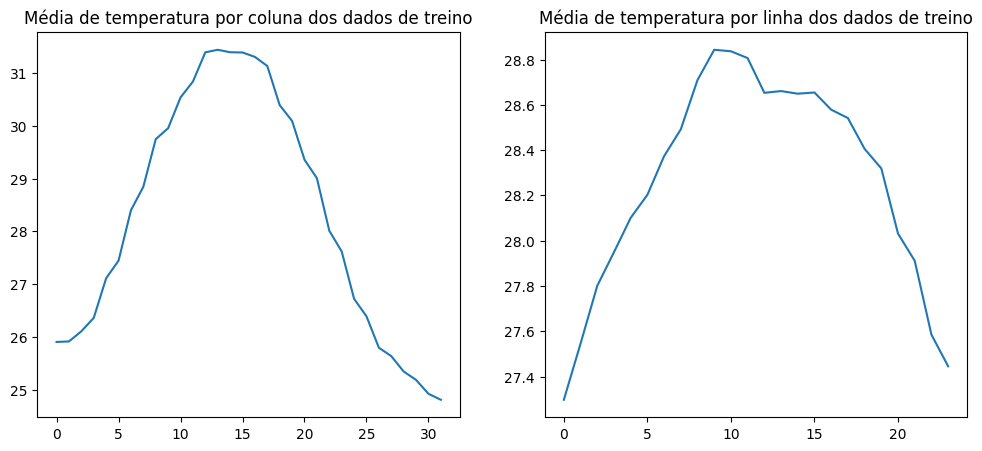

In [7]:
# distribuição média de pixels de cada coluna de cada imagem 'x' do train_set

sums = []
for i in train_set:
    img = i['x']
    sum_col = np.mean(img,axis=0)
    sums.append(sum_col)
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(np.mean(sums,axis=0))
plt.title('Média de temperatura por coluna dos dados de treino')

sums = []
for i in train_set:
    img = i['x']
    sum_col = np.mean(img,axis=1)
    sums.append(sum_col)

plt.subplot(1,2,2)
plt.plot(np.mean(sums,axis=0))
plt.title('Média de temperatura por linha dos dados de treino')
plt.show()

In [8]:
import numpy as np

train_set_arg = []

range_shift = 8

for n in range(-range_shift,range_shift+1):
    for i in train_set:
        img = i['x']
        min_id = np.argmin(np.mean(img, axis=0))  # Encontre a coluna com a menor temperatura média
        # converta os valores menores que a mediana dessa coluna para o valor da mediana
        img[:, min_id] = np.where(img[:, min_id] < np.median(img[:, min_id]), np.median(img[:, min_id]), img[:, min_id])
        min_id = np.argmin(np.mean(img, axis=0))
        shifted = np.roll(img, n, axis=1)  # Mova a imagem horizontalmente
        if n > 0:
            shifted[:, :n] = img[:, min_id:min_id+1]    # 
            shifted[:, :n] = shifted[:, :n] + np.random.normal(0, 0.25, shifted[:, :n].shape)
        else:
            shifted[:, n:] = img[:, min_id:min_id+1]  
            shifted[:, n:] = shifted[:, n:] + np.random.normal(0,0.25, shifted[:, n:].shape)

        train_set_arg.append({'x': shifted, 'y': i['y']})  # Adicione a imagem modificada ao conjunto de teste

train_set = train_set_arg.copy()

val_set_arg = []

for n in range(-range_shift,range_shift+1):
    for i in val_set:
        img = i['x']
        min_id = np.argmin(np.mean(img, axis=0))  # Encontre a coluna com a menor temperatura média
        # converta os valores menores que a mediana dessa coluna para o valor da mediana
        img[:, min_id] = np.where(img[:, min_id] < np.median(img[:, min_id]), np.median(img[:, min_id]), img[:, min_id])
        min_id = np.argmin(np.mean(img, axis=0))
        shifted = np.roll(img, n, axis=1)  # Mova a imagem horizontalmente
        if n > 0:
            shifted[:, :n] = img[:, min_id:min_id+1]    # 
            shifted[:, :n] = shifted[:, :n] + np.random.normal(0, 0.25, shifted[:, :n].shape)
        else:
            shifted[:, n:] = img[:, min_id:min_id+1]  
            shifted[:, n:] = shifted[:, n:] + np.random.normal(0,0.25, shifted[:, n:].shape)

        val_set_arg.append({'x': shifted, 'y': i['y']})  # Adicione a imagem modificada ao conjunto de teste

val_set = val_set_arg.copy()

In [25]:
# random forest

from sklearn.ensemble import RandomForestClassifier

# train random forest

rf = RandomForestClassifier(n_estimators=1000, max_depth=50, random_state=0)

# reshape x to 1d array

train_set = [{'x':x['x'].reshape(-1), 'y':x['y']} for x in train_set]
val_set = [{'x':x['x'].reshape(-1), 'y':x['y']} for x in val_set]

train_set2 = train_set + val_set

rf.fit([x['x'] for x in train_set2], [x['y'] for x in train_set2])

# test random forest

test_set = [{'x':x['x'].reshape(-1), 'y':x['y']} for x in test_set]

rf.score([x['x'] for x in test_set], [x['y'] for x in test_set])


0.9074074074074074

Text(0.5, 1.0, 'Feature Importance Random Forest')

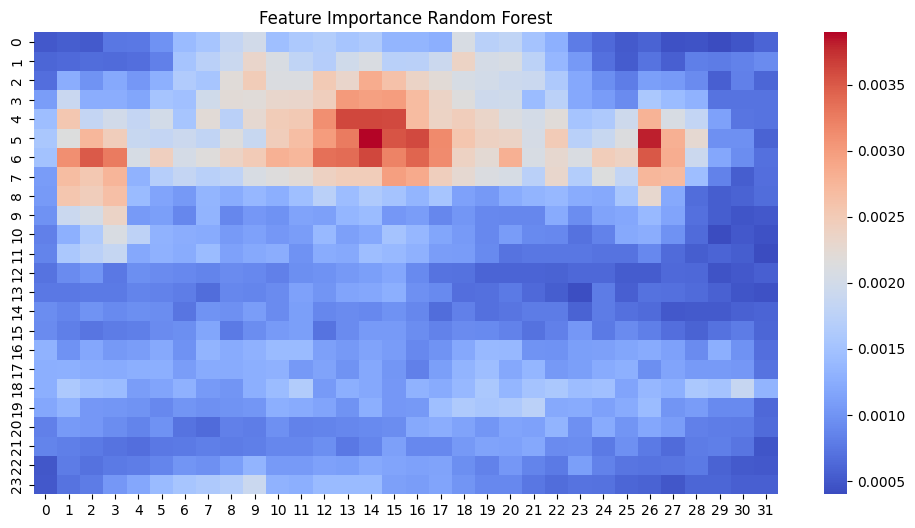

In [26]:
# plot feature importance

importances = rf.feature_importances_

importances = importances.reshape(24,32)

plt.figure(figsize=(12, 6))

seaborn.heatmap(importances, cmap='coolwarm', annot=False, fmt='.2f')

plt.title('Feature Importance Random Forest')

In [11]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, oob_score=True)
rf.fit([x['x'] for x in train_set], [x['y'] for x in train_set])
print(rf.oob_score_)

0.9068627450980392


In [12]:
val_set = [{'x':x['x'].reshape(-1), 'y':x['y']} for x in val_set]


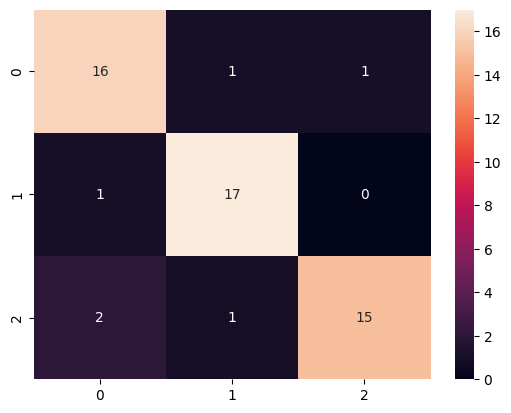

In [13]:
rf.score([x['x'] for x in train_set], [x['y'] for x in train_set])

# confusion matrix

from sklearn.metrics import confusion_matrix

confusion_matrix([x['y'] for x in test_set], rf.predict([x['x'] for x in test_set]))

# plot confusion matrix

import seaborn as sn

sn.heatmap(confusion_matrix([x['y'] for x in test_set], rf.predict([x['x'] for x in test_set])), annot=True)

plt.show()

In [14]:
# xgboost

import xgboost as xgb
import torch

# train xgboost

if torch.cuda.is_available():
    print('Using GPU')
    xgb_model = xgb.XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=3,
    n_estimators=3000,
    max_depth=7,
    learning_rate=0.01,
    verbosity=2,
    tree_method='gpu_hist',
    )
else:
    print('Using CPU')
    xgb_model = xgb.XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=3,
    n_estimators=3000,
    max_depth=10,
    learning_rate=0.01,
    verbosity=2
    )

xgb_model.fit([x['x'] for x in train_set], [x['y'] for x in train_set], 
              early_stopping_rounds=10, eval_set=[([x['x'] for x in val_set], [x['y'] for x in val_set])])

# test xgboost

xgb_model.score([x['x'] for x in test_set], [x['y'] for x in test_set])

Using CPU


c:\python3.9\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18:58:53] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=10
[18:58:53] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=10
[18:58:53] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-mlogloss:1.09287
[18:58:54] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=10
[18:58:54] INFO: C:\buildkite-agent\builds\buildkite-windows-c

0.9259259259259259

In [15]:
# plot data wrong classified by xgboost

wrong_classified = []

for i in range(len(test_set)):
    if test_set[i]['y'] != xgb_model.predict([test_set[i]['x']]):
        wrong_classified.append(i)

wrong_classified

[10, 28, 29, 48]

In [16]:
# # make plot of wrong classified data

# fig = plt.subplots(3,3)
# j = 1
# for i in wrong_classified:
#     plt.subplot(3,3,j)
#     plt.imshow(test_set[i]['x'].reshape(24,32))
#     plt.title('true: '+str(test_set[i]['y'])+' pred: '+str(xgb_model.predict([test_set[i]['x']])))
#     # set axis off
#     plt.axis('off')
    
#     j += 1

# plt.show()

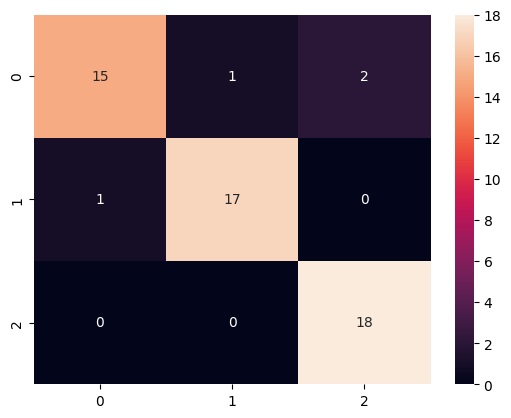

In [17]:
# plot confusion matrix

sn.heatmap(confusion_matrix([x['y'] for x in test_set], xgb_model.predict([x['x'] for x in test_set])), annot=True)

plt.show()

<Figure size 2000x3000 with 0 Axes>

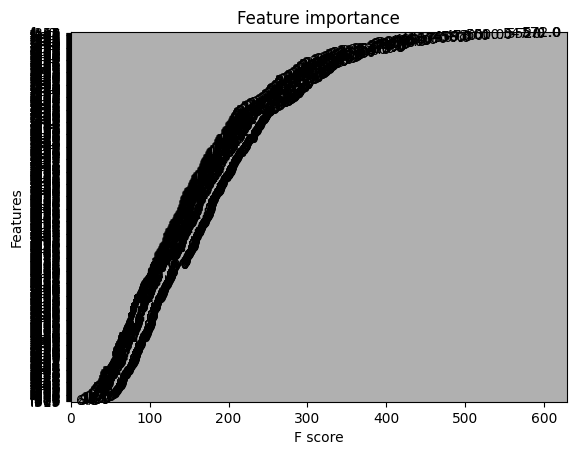

In [18]:
# plot feature importance

plt.figure(figsize=(20, 30))  # Adjust the size as needed
xgb.plot_importance(xgb_model)
plt.show()

train accuracy:  1.0
test accuracy:  0.8703703703703703


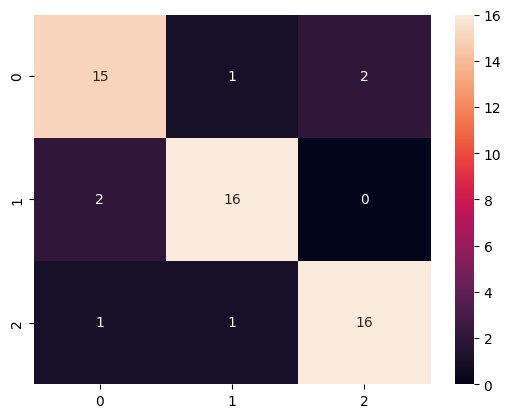

In [19]:
# using validation set to tune hyperparameters

xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42, max_depth=10, n_estimators=100)

xgb_model.fit([x['x'] for x in train_set], [x['y'] for x in train_set])

xgb_model.score([x['x'] for x in test_set], [x['y'] for x in test_set])

print('train accuracy: ', xgb_model.score([x['x'] for x in train_set], [x['y'] for x in train_set]))
print('test accuracy: ', xgb_model.score([x['x'] for x in test_set], [x['y'] for x in test_set]))
# confusion matrix

confusion_matrix([x['y'] for x in test_set], xgb_model.predict([x['x'] for x in test_set]))

# plot confusion matrix

sn.heatmap(confusion_matrix([x['y'] for x in test_set], xgb_model.predict([x['x'] for x in test_set])), annot=True)

plt.show()

In [20]:
# # plot wrong predictions

# wrong_predictions = [i for i in range(len(test_set)) if xgb_model.predict([test_set[i]['x']])[0] != test_set[i]['y']]

# fig = plt.subplots(2,3)
# j = 1
# for i in wrong_predictions:
#     plt.subplot(2,3,j)
#     plt.imshow(test_set[i]['x'].reshape(24,32))
#     plt.title('true: '+str(test_set[i]['y'])+' pred: '+str(xgb_model.predict([test_set[i]['x']])))
#     # set axis off
#     plt.axis('off')
    
#     j += 1

# plt.show()

In [21]:
# SVM 

from sklearn import svm

# train SVM

svm_model = svm.SVC(gamma='auto')

svm_model.fit([x['x'] for x in train_set], [x['y'] for x in train_set])

# test SVM

svm_model.score([x['x'] for x in test_set], [x['y'] for x in test_set])


0.9074074074074074

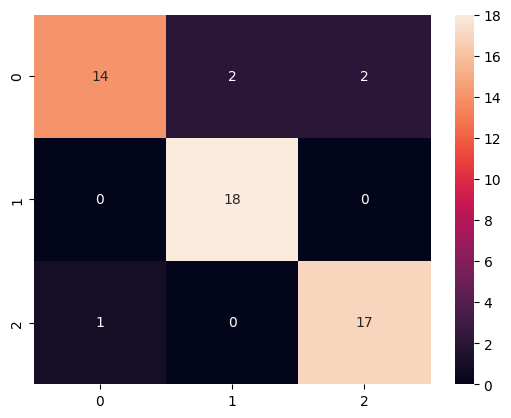

In [22]:
# plot confusion matrix

sn.heatmap(confusion_matrix([x['y'] for x in test_set], svm_model.predict([x['x'] for x in test_set])), annot=True)

plt.show()

In [23]:
# plot data wrong classified by xgboost

wrong_classified = []

for i in range(len(test_set)):
    if test_set[i]['y'] != xgb_model.predict([test_set[i]['x']]):
        wrong_classified.append(i)

wrong_classified

[6, 10, 21, 28, 29, 48, 51]

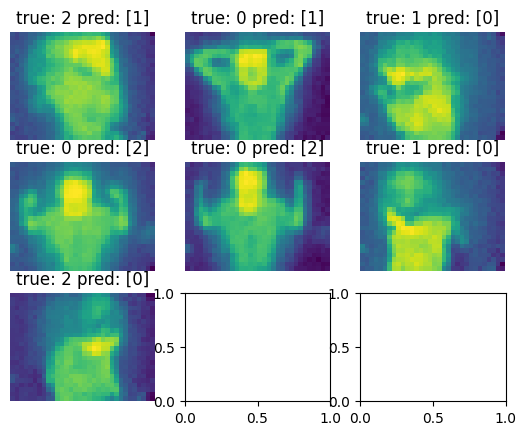

In [24]:
# make plot of wrong classified data

fig = plt.subplots(3,3)
j = 1
for i in wrong_classified:
    plt.subplot(3,3,j)
    plt.imshow(test_set[i]['x'].reshape(24,32))
    plt.title('true: '+str(test_set[i]['y'])+' pred: '+str(xgb_model.predict([test_set[i]['x']])))
    # set axis off
    plt.axis('off')
    
    j += 1

plt.show()